# Using Siphon to get NEXRAD Level 3 data from a TDS

First create an instance of RadarServer to point to the appropriate
radar server access URL. This hard-coding of a point should really be
replaced by scanning the top-level catalog, but that is still todo.

In [1]:
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level3/IDD/')

Look at the variables available in this dataset

In [2]:
rs.variables

{'DAA/Digital Accumulation Array',
 'DHR/Digital Hybrid Scan Reflectivity',
 'DOD/Digital One-Hour Difference Accumulation',
 'DPA/Digital Precipitation Array',
 'DPR/Digital Instantaneous Precipitation Rate',
 'DSD/Digital Storm Total Difference Accumulation',
 'DSP/Digital Storm Total Precipitation',
 'DTA/Digital Storm Total Accumulation',
 'DU3/Digital 3-hour Accumulation',
 'DU6/Digital 24-hour Accumulation',
 'DVL/Digital Vertically Integrated Liquid',
 'EET/Enchanced Echo Tops',
 'HHC/Hybrid Hydrometeor Classification',
 'N0C/Correlation Coefficient Tilt 1',
 'N0H/Hydrometeor Classification Tilt 1',
 'N0K/Specific Differential Phase Tilt 1',
 'N0M/Melting Layer Tilt 1',
 'N0Q/Base Reflectivity DR Tilt 1',
 'N0R/Base Reflectivity 124nm',
 'N0S/Storm-Rel Mean Vel Tilt 1',
 'N0U/Radial Velocity DV Tilt 1',
 'N0V/Radial Velocity 124nm',
 'N0X/Differential Reflectivity Tilt 1',
 'N0Z/Base Reflecitvity 248nm',
 'N1C/Correlation Coefficient Tilt 3',
 'N1H/Hydrometeor Classification Til

Create a new query object to help request the data. Using the chaining
methods, ask for data from radar FTG (Denver) for now for the product
N0Q, which is reflectivity data for the lowest tilt. We see that when the query
is represented as a string, it shows the encoded URL.

In [3]:
from datetime import datetime
query = rs.query()
query.stations('FTG').time(datetime.utcnow()).variables('N0Q')

var=N0Q&time=2015-06-16T22%3A23%3A23.076237&stn=FTG

We can use the RadarServer instance to check our query, to make
sure we have required parameters and that we have chosen valid
station(s) and variable(s)

In [4]:
rs.validate_query(query)

True

Make the request, which returns an instance of TDSCatalog. This
handles parsing the catalog

In [5]:
catalog = rs.get_catalog(query)

We can look at the datasets on the catalog to see what data we found by the query. We find one
NIDS file in the return

In [6]:
catalog.datasets

{'Level3_FTG_N0Q_20150616_2220.nids': <siphon.catalog.Dataset at 0x10b7f6cf8>}

We can pull that dataset out of the dictionary and look at the available access URLs. We see URLs for OPeNDAP, CDMRemote, and HTTPServer (direct download).

In [7]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/nexrad/level3/IDD/N0Q/FTG/20150616/Level3_FTG_N0Q_20150616_2220.nids',
 'HTTPServer': 'http://thredds.ucar.edu/thredds/fileServer/nexrad/level3/IDD/N0Q/FTG/20150616/Level3_FTG_N0Q_20150616_2220.nids',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/nexrad/level3/IDD/N0Q/FTG/20150616/Level3_FTG_N0Q_20150616_2220.nids'}

We'll use the CDMRemote reader in Siphon and pass it the appropriate access URL.

In [8]:
from siphon.cdmr import Dataset
data = Dataset(ds.access_urls['CdmRemote'])

The CDMRemote reader provides an interface that is almost identical to the usual python NetCDF interface. We pull out the variables we need for azimuth and range, as well as the data itself.

In [9]:
rng = data.variables['gate'][:] / 1000.
az = data.variables['azimuth'][:]
ref = data.variables['BaseReflectivityDR'][:]

Then convert the polar coordinates to Cartesian

In [10]:
import numpy as np
x = rng * np.sin(np.deg2rad(az))[:, None]
y = rng * np.cos(np.deg2rad(az))[:, None]
ref = np.ma.array(ref, mask=np.isnan(ref))

Finally, we plot them up using matplotlib.

(-460, 460)

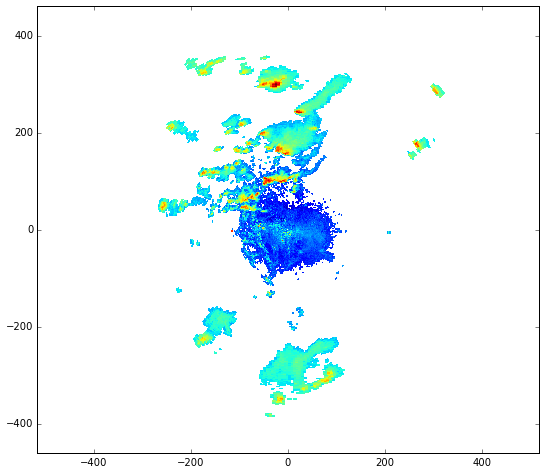

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.pcolormesh(x, y, ref)
ax.set_aspect('equal', 'datalim')
ax.set_xlim(-460, 460)
ax.set_ylim(-460, 460)